In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

train_df = pd.read_csv('~/rep/kaggle/playground-series-s5e8/train.csv')
test_df = pd.read_csv('~/rep/kaggle/playground-series-s5e8/test.csv')

In [2]:
train_df = train_df.drop(columns=['id'])
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [3]:
target = 'y'
feature_cols = [col for col in train_df.columns if target not in col]
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']
print(feature_cols)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'month', 'duration', 'campaign', 'previous', 'poutcome']


In [4]:
# Create a copy of the dataframes to avoid modifying originals
train_scaled = train_df.copy()
test_scaled = test_df.copy()

# Select columns to scale (exclude target column)
# - Only consider numeric columns
numeric_cols = train_scaled.select_dtypes(include=["number"]).columns
numeric_cols = [col for col in numeric_cols if col != target]
scaler = StandardScaler()

# Fit the scaler on the training data (numeric columns)
scaler.fit(train_scaled[numeric_cols])

# Transform both train and test data
train_scaled[numeric_cols] = scaler.transform(train_scaled[numeric_cols])
test_scaled[numeric_cols] = scaler.transform(test_scaled[numeric_cols])

In [5]:
# Create a copy of train and test dataframes to avoid modifying original dataframes
train_encoded = train_scaled.copy()
test_encoded = test_scaled.copy()

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for column in categorical_columns:
    print(f'Encoding: {column} ...')
    # Fit the label encoder on the train data
    le.fit(train_encoded[column])
    
    # Transform both train and test data using the same encoder
    train_encoded[column] = le.transform(train_encoded[column])
    if column in test_encoded.columns:
        # Handle cases where test set may have unseen labels by using fillna
        test_encoded[column] = test_encoded[column].map(lambda s: le.transform([s])[0] if s in le.classes_ else None)
        test_encoded[column].fillna(-1, inplace=True)
        test_encoded[column] = test_encoded[column].astype(int)

Encoding: job ...
Encoding: marital ...
Encoding: education ...
Encoding: default ...
Encoding: housing ...
Encoding: loan ...
Encoding: contact ...
Encoding: month ...
Encoding: poutcome ...


In [6]:
# Determine feature set
X = train_encoded[feature_cols]
X_test = test_encoded[feature_cols]

# Extract target values
y = train_encoded[target]

# Initialize the model with the specified parameters
model = XGBClassifier()

In [7]:
# run a grid search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=3)

grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.929 total time=   5.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.929 total time=   5.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.928 total time=   4.5s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.928 total time=   4.9s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.930 total time=   4.4s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.936 total time=   8.7s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.936 total time=   8.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.935 total time=   9.4s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.935 total time=   9.5s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.93

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'n_estimators': [100, 200]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [17]:
# 1. Accessing the best parameters and score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

print("\n--- Detailed Results ---")

# 2. Convert cv_results_ to a Pandas DataFrame for easier manipulation
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score to see the top performers
results_df_sorted = results_df.sort_values(by="mean_test_score", ascending=False)
print("Top 5 performing parameter combinations:")
print(results_df_sorted[['params', 'mean_test_score', 'std_test_score']].head())

# 3. Breakdown 'params' column for easier analysis
params_expanded = results_df_sorted['params'].apply(pd.Series)
results_df_sorted_expanded = pd.concat([results_df_sorted.drop(columns=['params']), params_expanded], axis=1)

print("\nTop 5 performing parameter combinations (expanded):")
results_df_sorted_expanded.head()

Best parameters found: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Best ROC AUC score: 0.9643

--- Detailed Results ---
Top 5 performing parameter combinations:
                                               params  mean_test_score  \
11  {'learning_rate': 0.1, 'max_depth': 9, 'n_esti...         0.964311   
17  {'learning_rate': 0.2, 'max_depth': 9, 'n_esti...         0.963911   
15  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...         0.963822   
16  {'learning_rate': 0.2, 'max_depth': 9, 'n_esti...         0.963790   
10  {'learning_rate': 0.1, 'max_depth': 9, 'n_esti...         0.963389   

    std_test_score  
11        0.000453  
17        0.000363  
15        0.000440  
16        0.000425  
10        0.000491  

Top 5 performing parameter combinations (expanded):


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,learning_rate,max_depth,n_estimators
11,16.302723,0.059604,0.320399,0.012321,0.1,9,200,0.964206,0.964718,0.964025,0.963683,0.964923,0.964311,0.000453,1,0.1,9.0,200.0
17,19.658462,0.385997,0.370686,0.008262,0.2,9,200,0.963822,0.964099,0.963604,0.963515,0.964514,0.963911,0.000363,2,0.2,9.0,200.0
15,11.199760,0.081024,0.200661,0.009182,0.2,6,200,0.963725,0.964181,0.963401,0.963335,0.964465,0.963822,0.000440,3,0.2,6.0,200.0
16,8.926925,1.228264,0.207011,0.038926,0.2,9,100,0.963586,0.964115,0.963450,0.963344,0.964454,0.963790,0.000425,4,0.2,9.0,100.0
10,10.576500,0.901518,0.207872,0.024728,0.1,9,100,0.963178,0.963771,0.963093,0.962773,0.964129,0.963389,0.000491,5,0.1,9.0,100.0


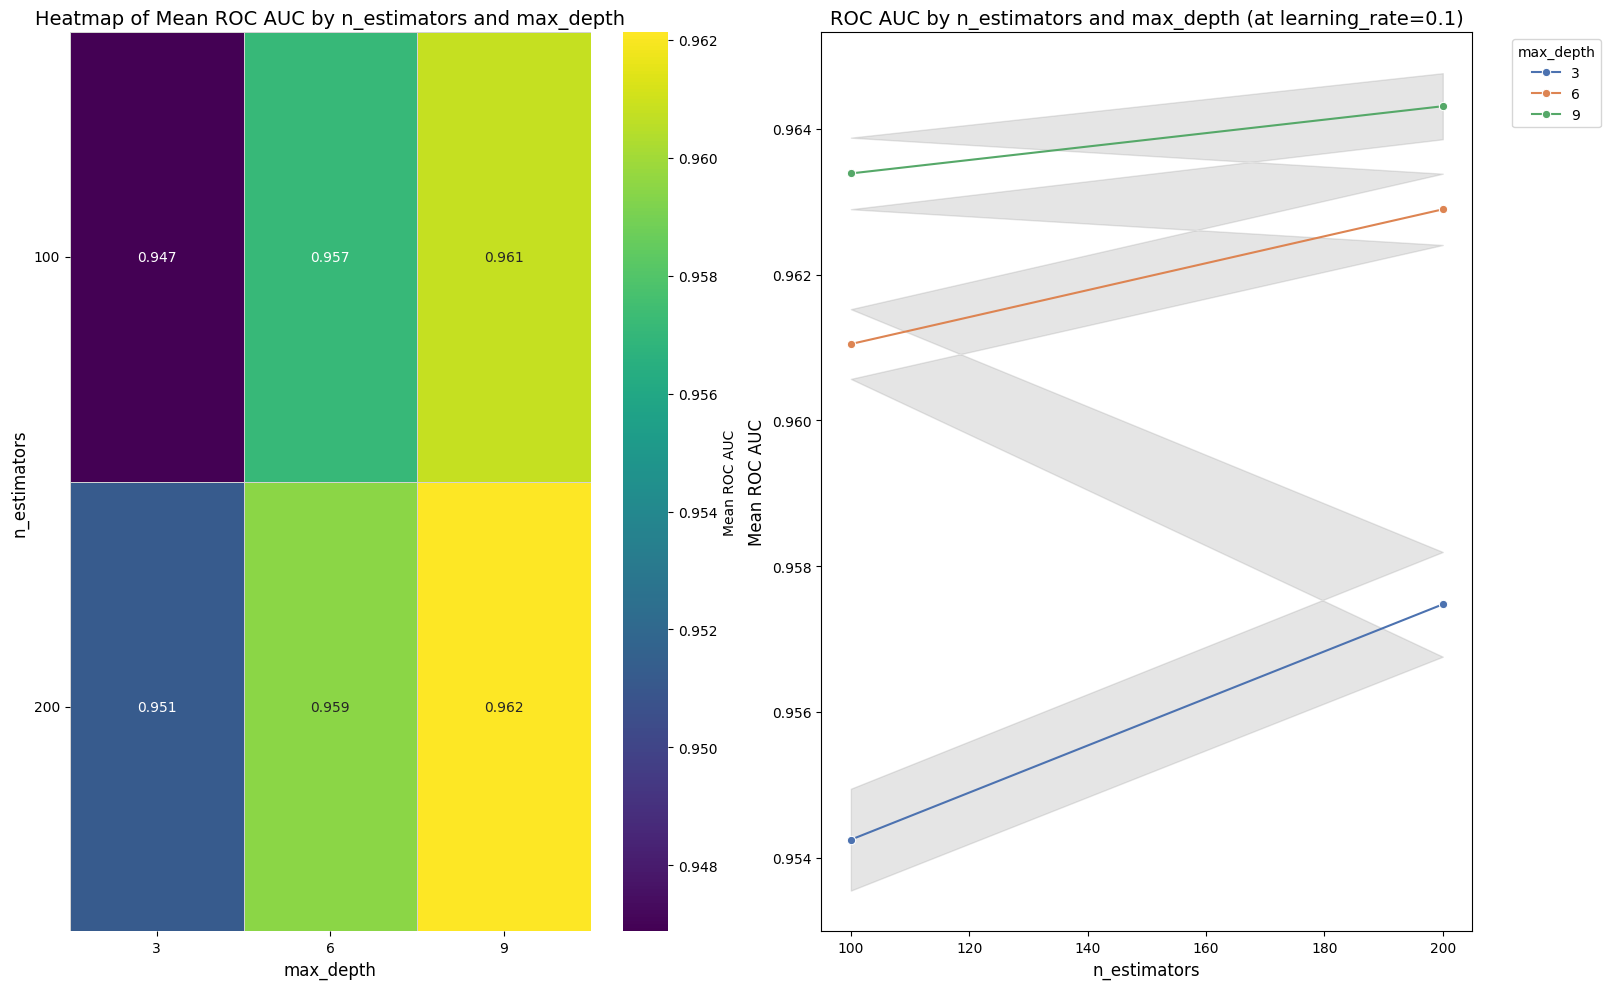

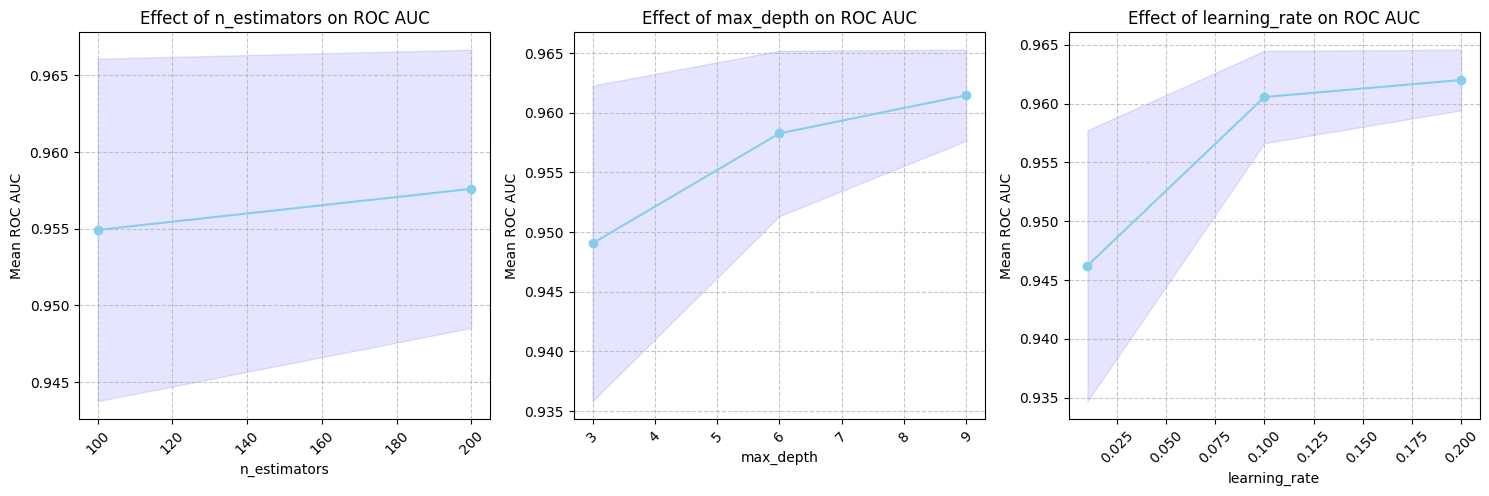

In [12]:
# Filter for relevant columns for plotting
param_cols = [col for col in results_df.columns if col.startswith('param_')]
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']]

# Rename columns for cleaner plotting (remove 'param_')
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# --- Visualization using Seaborn and Matplotlib ---
plt.figure(figsize=(18, 10))

# 3. Heatmap of mean_test_score for two chosen parameters (e.g., n_estimators vs max_depth)
# This requires pivoting the DataFrame. We'll iterate through pairs.
params_to_plot = list(grid_search.param_grid.keys())

if len(params_to_plot) >= 2:
    # Example: Plot n_estimators vs max_depth
    param1 = params_to_plot[0]
    param2 = params_to_plot[1]

    pivot_table = plot_df.pivot_table(index=param1, columns=param2, values='mean_test_score')

    plt.subplot(1, 2, 1) # Arrange plots in a grid
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", linewidths=.5, linecolor='lightgray', cbar_kws={'label': 'Mean ROC AUC'})
    plt.title(f'Heatmap of Mean ROC AUC by {param1} and {param2}', fontsize=14)
    plt.xlabel(param2, fontsize=12)
    plt.ylabel(param1, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)


    # 4. Line plots showing the effect of each parameter on mean_test_score
    # This is useful for seeing trends
    if len(params_to_plot) >= 3:
        # Example: Plot n_estimators vs learning_rate for a specific max_depth
        param3 = params_to_plot[2]

        # Choose one value for the third parameter to create separate plots or fix it
        # Here, we'll plot mean_test_score against one parameter, grouped by another, for the best value of the third.
        best_val_param3 = grid_search.best_params_[param3] # Using the best value of the third param

        plt.subplot(1, 2, 2)
        # Filter for the best_val_param3
        filtered_df = plot_df[plot_df[param3] == best_val_param3]

        sns.lineplot(data=filtered_df, x=param1, y='mean_test_score', hue=param2, marker='o', palette='deep')
        plt.fill_between(filtered_df[param1],
                         filtered_df['mean_test_score'] - filtered_df['std_test_score'],
                         filtered_df['mean_test_score'] + filtered_df['std_test_score'],
                         color='gray', alpha=0.2)
        plt.title(f'ROC AUC by {param1} and {param2} (at {param3}={best_val_param3})', fontsize=14)
        plt.xlabel(param1, fontsize=12)
        plt.ylabel('Mean ROC AUC', fontsize=12)
        plt.legend(title=param2, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to prevent legend overlap
    else:
        plt.subplot(1, 2, 2)
        # If only two parameters, plot one against the other with error bars
        sns.lineplot(data=plot_df, x=param1, y='mean_test_score', hue=param2, marker='o', palette='deep')
        # To add error bars, we need to ensure unique combinations for fill_between
        for p_val in plot_df[param2].unique():
            subset = plot_df[plot_df[param2] == p_val].sort_values(by=param1)
            plt.fill_between(subset[param1],
                             subset['mean_test_score'] - subset['std_test_score'],
                             subset['mean_test_score'] + subset['std_test_score'],
                             alpha=0.2)

        plt.title(f'ROC AUC by {param1} and {param2}', fontsize=14)
        plt.xlabel(param1, fontsize=12)
        plt.ylabel('Mean ROC AUC', fontsize=12)
        plt.legend(title=param2, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout(rect=[0, 0, 0.9, 1])

    plt.show() # Display the plots


    # 5. Individual parameter plots (if more than one parameter exists)
    num_params = len(params_to_plot)
    if num_params > 0:
        fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 5))
        if num_params == 1: # Handle single subplot case
            axes = [axes]

        for i, param_name in enumerate(params_to_plot):
            ax = axes[i]
            # Group by parameter and calculate mean and std of the score
            param_summary = plot_df.groupby(param_name)['mean_test_score'].agg(['mean', 'std']).reset_index()
            ax.plot(param_summary[param_name], param_summary['mean'], marker='o', color='skyblue')
            ax.fill_between(param_summary[param_name],
                            param_summary['mean'] - param_summary['std'],
                            param_summary['mean'] + param_summary['std'],
                            color='blue', alpha=0.1)
            ax.set_title(f'Effect of {param_name} on ROC AUC', fontsize=12)
            ax.set_xlabel(param_name, fontsize=10)
            ax.set_ylabel('Mean ROC AUC', fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

else:
    print("Not enough parameters to generate heatmap or line plots for combinations.")
    if len(params_to_plot) == 1:
        param_name = params_to_plot[0]
        param_summary = plot_df.groupby(param_name)['mean_test_score'].agg(['mean', 'std']).reset_index()
        plt.figure(figsize=(8, 5))
        plt.plot(param_summary[param_name], param_summary['mean'], marker='o', color='skyblue')
        plt.fill_between(param_summary[param_name],
                         param_summary['mean'] - param_summary['std'],
                         param_summary['mean'] + param_summary['std'],
                         color='blue', alpha=0.1)
        plt.title(f'Effect of {param_name} on ROC AUC', fontsize=14)
        plt.xlabel(param_name, fontsize=12)
        plt.ylabel('Mean ROC AUC', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No parameters found to plot.")

In [10]:
# run the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# save the predictions
submission_df = pd.DataFrame({'id': test_df['id'], 'y': y_pred})
submission_df.to_csv('submission.csv', index=False)